In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import ffmpeg
from PIL import Image

In [2]:
device = torch.device('cuda')

N_HIDDEN = 8
WIDTH = 12

FRAMES = 300

# 4K
RESOLUTION_X = 3840
RESOLUTION_Y = 2160

# 1080p
# RESOLUTION_X = 1920
# RESOLUTION_Y = 1080

In [3]:
def getLinear(in_dims, out_dims):
    layer = torch.nn.Linear(in_dims, out_dims)
    torch.nn.init.uniform_(layer.weight, -2.0, 2.0)
    return layer

In [4]:
def getModel():
    layers = [
        getLinear(3, WIDTH),
        torch.nn.Tanh()
    ]

    for i in range(N_HIDDEN):
        layers.append(getLinear(WIDTH, WIDTH))
        layers.append(torch.nn.Tanh())

    layers.append(getLinear(WIDTH, 3))
    layers.append(torch.nn.Sigmoid())

    model = torch.nn.Sequential(*layers)
    model = model.to(device)
    
    return model

In [5]:
model = getModel()

model.requires_grad_(False)

phases = []

RADIUS = 1.0

for p in model.parameters():
    phase_tensor = torch.rand_like(p) * 2 * np.pi
    phases.append(phase_tensor)

def get_output(last_time, new_time, inputs):
    for phase, param in zip(phases, model.parameters()):
        last_wave = torch.sin(phase + last_time)
        new_wave = torch.sin(phase + new_time)
        param += RADIUS * (new_wave - last_wave)
        
    with torch.no_grad():
        out_flat = model(inputs)
        
    return out_flat.to('cpu').reshape(RESOLUTION_Y, RESOLUTION_X, 3).numpy()

In [6]:
img = np.array(Image.open('./inputs/circle_4k.png')).astype(np.float32)
img -= img.min()
img /= img.max()
img = (img * 2) - 1

img = img[:, :, np.newaxis]
print(img.shape)

(2160, 3840, 1)


In [7]:
coords_x = np.linspace(start=-1, stop=1, num=RESOLUTION_X, dtype=np.float32)
# coords_x = np.sin(np.linspace(start=0, stop=np.pi, num=RESOLUTION_X, dtype=np.float32))
# coords_x = (coords_x * 2) - 1
# coords_x *= 0.5

coords_y = np.linspace(start=-1, stop=1, num=RESOLUTION_Y, dtype=np.float32)
# coords_y = np.sin(np.linspace(start=0, stop=np.pi, num=RESOLUTION_Y, dtype=np.float32))
# coords_y = (coords_y * 2) - 1
# coords_y *= 0.5


coords = np.stack(np.meshgrid(coords_x, coords_y))
coords = np.transpose(coords, [1, 2, 0])

coords = np.concatenate([coords, img], axis=2)

# Change scale of channels
coords[:, :, :2] *= 1.0 # x, y channels
coords[:, :, 2:] *= 0.2 # image channels

coords_flat = coords.reshape(-1, 3)
coords_flat = torch.tensor(coords_flat).to(torch.float)
coords_flat = coords_flat.to(device)

times = np.linspace(start=0, stop=2 * np.pi, num=FRAMES, dtype=np.float32)

In [8]:
frames = []

for i in range(FRAMES - 1):
    old_time = times[i]
    new_time = times[i + 1]
    frame = get_output(old_time, new_time, coords_flat)
    frames.append(frame)

In [9]:
frames = np.stack(frames) * 255

In [10]:
# From: https://github.com/kkroening/ffmpeg-python/issues/246

# frames_in = np.transpose(frames, [2, 1, 0, 3]) * 255

def vidwrite(fn, images, framerate=60, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [11]:
vidwrite("out_new.mp4", frames)

In [22]:
1+1

2

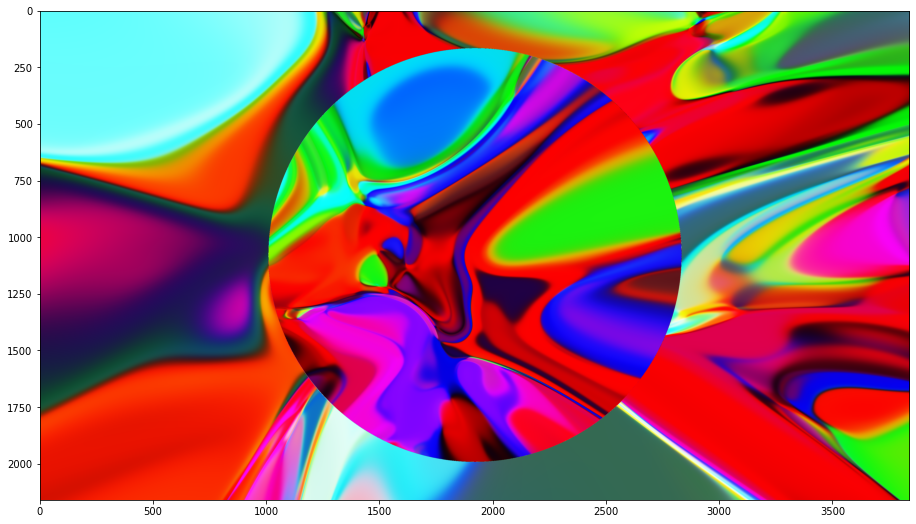

In [23]:
plt.figure(figsize=(16, 9))
plt.imshow(frames[50] / 255)